In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import spacy
from tqdm import tqdm
import tensorflow as tf
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

2024-10-08 14:52:12.631529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 14:52:12.649558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 14:52:12.649595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 14:52:12.662542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 14:52:13.392468: W tensorflow/com

In [2]:
import pandas as pd

train = pd.read_csv('train.csv')
valid_hc3si = pd.read_csv('val_hc3_si.csv')
valid_hc3qa = pd.read_csv('val_hc3.csv')
test_hc3si = pd.read_csv('test_hc3_si.csv')
test_hc3qa = pd.read_csv('test_hc3.csv')

In [3]:
valid = pd.concat([valid_hc3si, valid_hc3qa], ignore_index=True)
valid

,text,label
0,"Engineering multinational, Arup, has released ...",1
1,A hostage situation and fatal police standoff ...,1
2,"Authorities took Eugene, Oregon man Jeffrey Wr...",0
3,"Inter Milan, despite resting several key playe...",1
4,Scientists hope deadly creatures can save huma...,0
...,...,...
16487,I will now sum up the Illuminati for you . Rea...,0
16488,Game programmers will need to have a perfectly...,0
16489,You can see stars thousands of light years awa...,0
16490,Just yesterday saw an article saying that worm...,0


In [4]:
test_original = pd.concat([test_hc3si, test_hc3qa], ignore_index=True)
test_original

,text,label
0,Can you provide more context? Is this part of ...,1
1,"Please explain what is ""Artificial intelligence""",0
2,Is it good to have oil at a lower price? Some ...,1
3,Is n't cheap oil a good thing ? Sometimes I re...,0
4,In which films has Taylor Lautner appeared?,1
...,...,...
63186,There are several possible causes of pain that...,1
63187,you are allergic to caffeineanybody can be all...,0
63188,It's possible that you are experiencing caffei...,1
63189,Hello!Welcome and thank you for asking on HCM!...,0


In [5]:
valid.to_csv('valid.csv', index=False)

In [6]:
test_original.to_csv('test_original.csv', index=False)

In [7]:
shuffled_test_original = test_original.sample(frac=1, random_state=42).reset_index(drop=True)
test_duplicate = shuffled_test_original.iloc[:14840]
test_duplicate

,text,label
0,You could forgive Apple's legal team for comin...,0
1,Liberal and conservative are two different way...,1
2,The sun is also white . It just appears yellow...,0
3,North Lanarkshire Council in Scotland has laun...,1
4,"""I was looking for something that was comparab...",0
...,...,...
14835,These Vienna talks for the first time include ...,0
14836,India's film censorship board has granted a ce...,1
14837,"Expanding ammunition, also known as hollow poi...",1
14838,They will have in-depth discussions on relatio...,0


In [8]:
test_duplicate.to_csv('test_duplicate.csv', index=False)

In [9]:
label_counts_train = train['label'].value_counts()

label_counts_valid_hc3si = valid_hc3si['label'].value_counts()
label_counts_valid_hc3qa = valid_hc3qa['label'].value_counts()
label_counts_valid = valid['label'].value_counts()

label_counts_test_hc3si = test_hc3si['label'].value_counts()
label_counts_test_hc3qa = test_hc3qa['label'].value_counts()
label_counts_test_original = test_original['label'].value_counts()
label_counts_test_duplicate = test_duplicate['label'].value_counts()

In [10]:
label_counts_train, label_counts_valid_hc3si, label_counts_valid_hc3qa, label_counts_valid, label_counts_test_hc3si, label_counts_test_hc3qa, label_counts_test_original, label_counts_test_duplicate

(label
 0    83582
 1    64820
 Name: count, dtype: int64,
 label
 0    5387
 1    5254
 Name: count, dtype: int64,
 label
 0    3957
 1    1894
 Name: count, dtype: int64,
 label
 0    9344
 1    7148
 Name: count, dtype: int64,
 label
 1    19071
 0    19071
 Name: count, dtype: int64,
 label
 0    17031
 1     8018
 Name: count, dtype: int64,
 label
 0    36102
 1    27089
 Name: count, dtype: int64,
 label
 0    8529
 1    6311
 Name: count, dtype: int64)

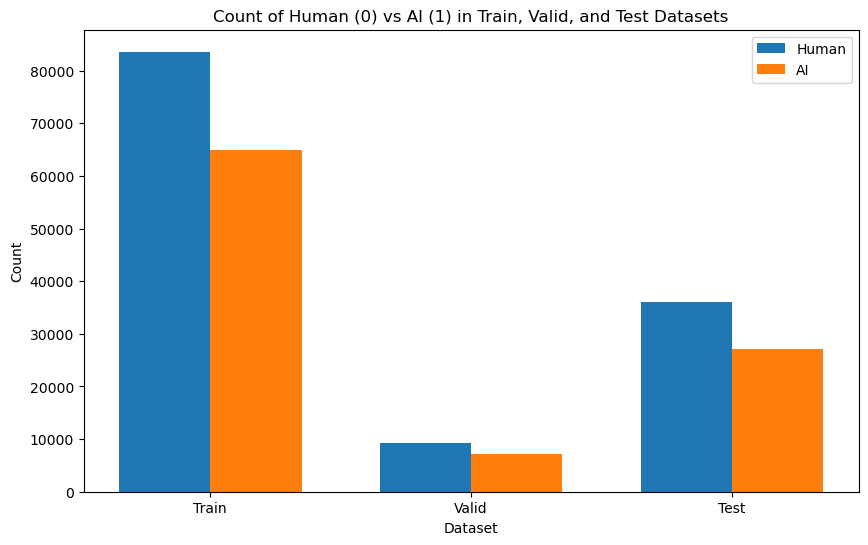

In [11]:
human_counts = [
    label_counts_train.get(0, 0),  
    label_counts_valid.get(0, 0),  
    label_counts_test_original.get(0, 0) 
]

ai_counts = [
    label_counts_train.get(1, 0), 
    label_counts_valid.get(1, 0), 
    label_counts_test_original.get(1, 0) 
]

labels = ['Train', 'Valid', 'Test']
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_human = ax.bar(x - width/2, human_counts, width, label='Human')
bars_ai = ax.bar(x + width/2, ai_counts, width, label='AI')

ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Count of Human (0) vs AI (1) in Train, Valid, and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()

plt.show()


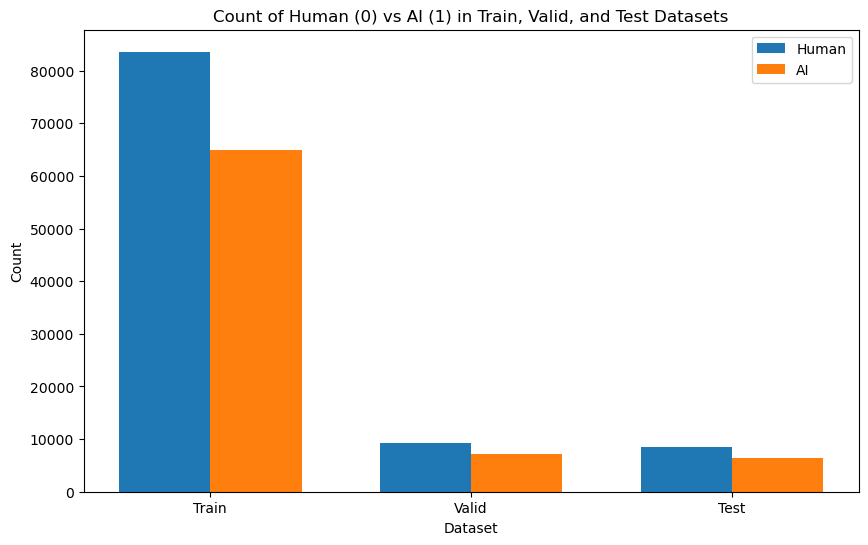

In [12]:
human_counts = [
    label_counts_train.get(0, 0),  
    label_counts_valid.get(0, 0),  
    label_counts_test_duplicate.get(0, 0) 
]

ai_counts = [
    label_counts_train.get(1, 0), 
    label_counts_valid.get(1, 0), 
    label_counts_test_duplicate.get(1, 0) 
]

labels = ['Train', 'Valid', 'Test']
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars_human = ax.bar(x - width/2, human_counts, width, label='Human')
bars_ai = ax.bar(x + width/2, ai_counts, width, label='AI')

ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Count of Human (0) vs AI (1) in Train, Valid, and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()

plt.show()


In [13]:
class TextPreprocessor:
    def __init__(self, data):
        self.data = data
        self.nlp = spacy.load('en_core_web_sm')
        self.stemmer = SnowballStemmer('english')
    
    def clean_text(self, text):
        """Clean the input text by removing URLs, mentions, hashtags, numbers, punctuations, etc."""
        text = re.sub(r"@\S+", "", text)  
        text = re.sub(r"http[s]?\://\S+", "", text) 
        text = re.sub(r"#\S+", "", text)  
        text = re.sub(r"[0-9]", "", text) 
        text = re.sub(r"[\[\]()]", "", text)
        text = re.sub(r"\n", "", text)  
        text = text.translate(str.maketrans('', '', string.punctuation)) 
        text = re.sub(r'[^\w\s]', '', text) 
        text = text.lower()  
        text = re.sub(r"\s+", " ", text).strip()  
        return text if text else "no text"
    
    def lemmatize_sentence(self, sentence):
        """Apply lemmatization to a sentence using SpaCy."""
        doc = self.nlp(sentence)
        lemmatized_sentence = " ".join([token.lemma_ for token in doc])
        return lemmatized_sentence
    
    def stem_sentence(self, sentence):
        """Apply stemming to a sentence using NLTK's Snowball Stemmer."""
        words = sentence.split()
        stemmed_words = [self.stemmer.stem(word) for word in words]
        stemmed_sentence = " ".join(stemmed_words)
        return stemmed_sentence
    
    def pos_tagging(self, sentence):
        """Perform POS tagging on a sentence using SpaCy."""
        doc = self.nlp(sentence)
        pos_tags = [token.pos_ for token in doc]
        return " ".join(pos_tags)
    
    def process_data(self):
        """Process the entire DataFrame, applying cleaning, lemmatization, stemming, and POS tagging."""
        self.data['clean_text'] = self.data['text'].apply(self.clean_text)
        
        lemmatized_text = []
        for sentence in tqdm(self.data['clean_text'], desc='Lemmatizing'):
            lemmatized_sentence = self.lemmatize_sentence(sentence)
            lemmatized_text.append(lemmatized_sentence)
        self.data['lemmatized_text'] = lemmatized_text
        
        stemmed_text = []
        for sentence in tqdm(self.data['clean_text'], desc='Stemming'):
            stemmed_sentence = self.stem_sentence(sentence)
            stemmed_text.append(stemmed_sentence)
        self.data['stemmed_text'] = stemmed_text
        
        pos_tags = []
        for sentence in tqdm(self.data['clean_text'], desc='POS tagging'):
            pos_sentence = self.pos_tagging(sentence)
            pos_tags.append(pos_sentence)
        self.data['pos'] = pos_tags
    
    def get_processed_data(self):
        """Return the processed DataFrame with clean_text, lemmatized_text, stemmed_text, and pos columns."""
        return self.data

In [14]:
train_preprocessor = TextPreprocessor(train)
train_preprocessor.process_data()
train_data = train_preprocessor.get_processed_data()

POS tagging: 100%|█████████████████████| 148402/148402 [22:58<00:00, 107.64it/s]


In [15]:
valid_preprocessor = TextPreprocessor(valid)
valid_preprocessor.process_data()
valid_data = valid_preprocessor.get_processed_data()

POS tagging: 100%|███████████████████████| 16492/16492 [02:33<00:00, 107.58it/s]


In [16]:
test_original_preprocessor = TextPreprocessor(test_original)
test_original_preprocessor.process_data()
test_original_data = test_original_preprocessor.get_processed_data()

POS tagging: 100%|███████████████████████| 63191/63191 [10:04<00:00, 104.48it/s]


In [17]:
test_duplicate_preprocessor = TextPreprocessor(test_duplicate)
test_duplicate_preprocessor.process_data()
test_duplicate_data = test_duplicate_preprocessor.get_processed_data()

/tmp/ipykernel_7205/2444588702.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['clean_text'] = self.data['text'].apply(self.clean_text)
Lemmatizing: 100%|████████████████████████| 14840/14840 [02:29<00:00, 99.28it/s]
/tmp/ipykernel_7205/2444588702.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['lemmatized_text'] = lemmatized_text
Stemming: 100%|█████████████████████████| 14840/14840 [00:06<00:00, 2170.24it/s]
/tmp/ipykernel_7205/2444588702.py:54: SettingWithCopyWarning: 
A val

In [18]:
train_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos
0,"AC Milan coach, Pippo Inzaghi, took some of hi...",1,ac milan coach pippo inzaghi took some of his ...,ac milan coach pippo inzaghi take some of his ...,ac milan coach pippo inzaghi took some of his ...,PROPN PROPN PROPN PROPN PROPN VERB PRON ADP PR...
1,Pam Jackson and Cheryl Miller were last seen o...,0,pam jackson and cheryl miller were last seen o...,pam jackson and cheryl miller be last see on m...,pam jackson and cheryl miller were last seen o...,PROPN PROPN CCONJ PROPN PROPN AUX ADV VERB ADP...
2,A female Tawny Frogmouth born at the St. Louis...,1,a female tawny frogmouth born at the st louis ...,a female tawny frogmouth bear at the st louis ...,a femal tawni frogmouth born at the st loui zo...,DET ADJ NOUN NOUN VERB ADP DET PROPN PROPN NOU...
3,Victoria Azarenka has been struggling with a f...,0,victoria azarenka has been struggling with a f...,victoria azarenka have be struggle with a foot...,victoria azarenka has been struggl with a foot...,PROPN PROPN AUX AUX VERB ADP DET NOUN NOUN NOU...
4,A photograph has emerged of a baby crawling pe...,1,a photograph has emerged of a baby crawling pe...,a photograph have emerge of a baby crawl peril...,a photograph has emerg of a babi crawl peril c...,DET NOUN AUX VERB ADP DET NOUN VERB ADV ADJ AD...
...,...,...,...,...,...,...
148397,"Hi, Welcome to Health care magic forum. ...",0,hi welcome to health care magic forum it is co...,hi welcome to health care magic forum it be co...,hi welcom to health care magic forum it is con...,INTJ VERB ADP NOUN NOUN NOUN NOUN PRON AUX VER...
148398,"The water is constantly recycled , so it does ...",0,the water is constantly recycled so it does nt...,the water be constantly recycle so it do not m...,the water is constant recycl so it doe nt matt...,DET NOUN AUX ADV VERB SCONJ PRON AUX PART VERB...
148399,"Nothing . Spain wo n't recognise it , the EU w...",0,nothing spain wo nt recognise it the eu wo nt ...,nothing spain will not recognise it the eu wil...,noth spain wo nt recognis it the eu wo nt reco...,PRON PROPN AUX PART VERB PRON DET PROPN AUX PA...
148400,Writing a short poem In seventeen syllables Is...,0,writing a short poem in seventeen syllables is...,write a short poem in seventeen syllable be ve...,write a short poem in seventeen syllabl is ver...,VERB DET ADJ NOUN ADP NUM NOUN AUX ADV ADJ


In [19]:
valid_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos
0,"Engineering multinational, Arup, has released ...",1,engineering multinational arup has released a ...,engineering multinational arup have release a ...,engin multin arup has releas a report entitl i...,NOUN ADJ NOUN AUX VERB DET NOUN VERB PRON ADJ ...
1,A hostage situation and fatal police standoff ...,1,a hostage situation and fatal police standoff ...,a hostage situation and fatal police standoff ...,a hostag situat and fatal polic standoff erupt...,DET NOUN NOUN CCONJ ADJ NOUN NOUN VERB ADP DET...
2,"Authorities took Eugene, Oregon man Jeffrey Wr...",0,authorities took eugene oregon man jeffrey wri...,authority take eugene oregon man jeffrey wrigh...,author took eugen oregon man jeffrey wright le...,NOUN VERB NOUN PROPN PROPN PROPN PROPN VERB AD...
3,"Inter Milan, despite resting several key playe...",1,inter milan despite resting several key player...,inter milan despite rest several key player su...,inter milan despit rest sever key player such ...,PROPN PROPN SCONJ VERB ADJ ADJ NOUN ADJ ADP NO...
4,Scientists hope deadly creatures can save huma...,0,scientists hope deadly creatures can save huma...,scientist hope deadly creature can save human ...,scientist hope dead creatur can save human gil...,NOUN VERB ADJ NOUN AUX VERB NOUN VERB NOUN NOU...
...,...,...,...,...,...,...
16487,I will now sum up the Illuminati for you . Rea...,0,i will now sum up the illuminati for you ready...,I will now sum up the illuminati for you ready...,i will now sum up the illuminati for you readi...,PRON AUX ADV VERB ADP DET NOUN ADP PRON ADJ NO...
16488,Game programmers will need to have a perfectly...,0,game programmers will need to have a perfectly...,game programmer will need to have a perfectly ...,game programm will need to have a perfect comp...,NOUN NOUN AUX VERB PART VERB DET ADV VERB NOUN...
16489,You can see stars thousands of light years awa...,0,you can see stars thousands of light years awa...,you can see star thousand of light year away j...,you can see star thousand of light year away j...,PRON AUX VERB NOUN NOUN ADP ADJ NOUN ADV ADV V...
16490,Just yesterday saw an article saying that worm...,0,just yesterday saw an article saying that worm...,just yesterday see an article say that worm ha...,just yesterday saw an articl say that worm hav...,ADV NOUN VERB DET NOUN VERB SCONJ NOUN AUX VER...


In [20]:
test_original_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos
0,Can you provide more context? Is this part of ...,1,can you provide more context is this part of a...,can you provide more context be this part of a...,can you provid more context is this part of a ...,AUX PRON VERB ADJ NOUN AUX DET NOUN ADP DET AD...
1,"Please explain what is ""Artificial intelligence""",0,please explain what is artificial intelligence,please explain what be artificial intelligence,pleas explain what is artifici intellig,INTJ VERB PRON AUX ADJ NOUN
2,Is it good to have oil at a lower price? Some ...,1,is it good to have oil at a lower price some n...,be it good to have oil at a low price some new...,is it good to have oil at a lower price some n...,AUX PRON ADJ PART VERB NOUN ADP DET ADJ NOUN D...
3,Is n't cheap oil a good thing ? Sometimes I re...,0,is nt cheap oil a good thing sometimes i read ...,be not cheap oil a good thing sometimes I read...,is nt cheap oil a good thing sometim i read he...,AUX PART ADJ NOUN DET ADJ NOUN ADV PRON VERB N...
4,In which films has Taylor Lautner appeared?,1,in which films has taylor lautner appeared,in which film have taylor lautner appear,in which film has taylor lautner appear,ADP PRON NOUN VERB PROPN NOUN VERB
...,...,...,...,...,...,...
63186,There are several possible causes of pain that...,1,there are several possible causes of pain that...,there be several possible cause of pain that r...,there are sever possibl caus of pain that radi...,PRON VERB ADJ ADJ NOUN ADP NOUN PRON VERB ADP ...
63187,you are allergic to caffeineanybody can be all...,0,you are allergic to caffeineanybody can be all...,you be allergic to caffeineanybody can be alle...,you are allerg to caffeineanybodi can be aller...,PRON AUX ADJ ADP NOUN AUX AUX ADJ PART VERB AU...
63188,It's possible that you are experiencing caffei...,1,its possible that you are experiencing caffein...,its possible that you be experience caffeine i...,it possibl that you are experienc caffein into...,PRON ADJ SCONJ PRON AUX VERB NOUN NOUN PRON AU...
63189,Hello!Welcome and thank you for asking on HCM!...,0,hellowelcome and thank you for asking on hcmre...,hellowelcome and thank you for ask on hcmregar...,hellowelcom and thank you for ask on hcmregard...,VERB CCONJ VERB PRON ADP VERB ADP VERB PRON NO...


In [21]:
test_duplicate_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos
0,You could forgive Apple's legal team for comin...,0,you could forgive apples legal team for coming...,you could forgive apple legal team for come ac...,you could forgiv appl legal team for come acro...,PRON AUX VERB NOUN ADJ NOUN ADP VERB ADP DET A...
1,Liberal and conservative are two different way...,1,liberal and conservative are two different way...,liberal and conservative be two different way ...,liber and conserv are two differ way of think ...,ADJ CCONJ ADJ AUX NUM ADJ NOUN ADP VERB ADP NO...
2,The sun is also white . It just appears yellow...,0,the sun is also white it just appears yellow next,the sun be also white it just appear yellow next,the sun is also white it just appear yellow next,DET NOUN AUX ADV ADJ PRON ADV VERB ADJ ADP
3,North Lanarkshire Council in Scotland has laun...,1,north lanarkshire council in scotland has laun...,north lanarkshire council in scotland have lau...,north lanarkshir council in scotland has launc...,PROPN PROPN PROPN ADP PROPN AUX VERB DET NOUN ...
4,"""I was looking for something that was comparab...",0,i was looking for something that was comparabl...,I be look for something that be comparable for...,i was look for someth that was compar for my p...,PRON AUX VERB ADP PRON PRON AUX ADJ ADP PRON NOUN
...,...,...,...,...,...,...
14835,These Vienna talks for the first time include ...,0,these vienna talks for the first time include ...,these vienna talk for the first time include a...,these vienna talk for the first time includ al...,DET NOUN VERB ADP DET ADJ NOUN VERB DET DET AD...
14836,India's film censorship board has granted a ce...,1,indias film censorship board has granted a cer...,indias film censorship board have grant a cert...,india film censorship board has grant a certif...,PROPN PROPN NOUN NOUN AUX VERB DET NOUN ADP DE...
14837,"Expanding ammunition, also known as hollow poi...",1,expanding ammunition also known as hollow poin...,expand ammunition also know as hollow point bu...,expand ammunit also known as hollow point bull...,VERB NOUN ADV VERB ADP ADJ NOUN NOUN AUX VERB ...
14838,They will have in-depth discussions on relatio...,0,they will have indepth discussions on relation...,they will have indepth discussion on relation ...,they will have indepth discuss on relat betwee...,PRON AUX VERB ADJ NOUN ADP NOUN ADP DET NUM NO...


In [22]:
train_data['combined_text'] = train_data['clean_text'] + ' ' + train_data['lemmatized_text'] + ' ' + train_data['stemmed_text'] + ' ' + train_data['pos']
valid_data['combined_text'] = valid_data['clean_text'] + ' ' + valid_data['lemmatized_text'] + ' ' + valid_data['stemmed_text'] + ' ' + valid_data['pos']
test_original_data['combined_text'] = test_original_data['clean_text'] + ' ' + test_original_data['lemmatized_text'] + ' ' + test_original_data['stemmed_text'] + ' ' + test_original_data['pos']
test_duplicate_data['combined_text'] = test_duplicate_data['clean_text'] + ' ' + test_duplicate_data['lemmatized_text'] + ' ' + test_duplicate_data['stemmed_text'] + ' ' + test_duplicate_data['pos']

/tmp/ipykernel_7205/2826795681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_duplicate_data['combined_text'] = test_duplicate_data['clean_text'] + ' ' + test_duplicate_data['lemmatized_text'] + ' ' + test_duplicate_data['stemmed_text'] + ' ' + test_duplicate_data['pos']


In [24]:
code_with_error1 = 'train_data.to_csv("train_data.csv", index=False)'
code_with_error2 = 'valid_data.to_csv("valid_data.csv", index=False)'
code_with_error3 = 'test_original_data.to_csv("test_original_data.csv", index=False)'
code_with_error4 = 'test_duplicate_data.to_csv("test_duplicate_data.csv", index=False)'

code_without_nbsp1 = code_with_error1.replace('\u00A0', ' ')
code_without_nbsp2 = code_with_error2.replace('\u00A0', ' ')
code_without_nbsp3 = code_with_error3.replace('\u00A0', ' ')
code_without_nbsp4 = code_with_error4.replace('\u00A0', ' ')

exec(code_without_nbsp1)
exec(code_without_nbsp2)
exec(code_without_nbsp3)
exec(code_without_nbsp4)

In [2]:
import pandas as pd

train_data = pd.read_csv("train_data.csv")
test_original_data = pd.read_csv("test_original_data.csv")
valid_data = pd.read_csv("valid_data.csv")

In [3]:
train_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos,combined_text
0,"AC Milan coach, Pippo Inzaghi, took some of hi...",1,ac milan coach pippo inzaghi took some of his ...,ac milan coach pippo inzaghi take some of his ...,ac milan coach pippo inzaghi took some of his ...,PROPN PROPN PROPN PROPN PROPN VERB PRON ADP PR...,ac milan coach pippo inzaghi took some of his ...
1,Pam Jackson and Cheryl Miller were last seen o...,0,pam jackson and cheryl miller were last seen o...,pam jackson and cheryl miller be last see on m...,pam jackson and cheryl miller were last seen o...,PROPN PROPN CCONJ PROPN PROPN AUX ADV VERB ADP...,pam jackson and cheryl miller were last seen o...
2,A female Tawny Frogmouth born at the St. Louis...,1,a female tawny frogmouth born at the st louis ...,a female tawny frogmouth bear at the st louis ...,a femal tawni frogmouth born at the st loui zo...,DET ADJ NOUN NOUN VERB ADP DET PROPN PROPN NOU...,a female tawny frogmouth born at the st louis ...
3,Victoria Azarenka has been struggling with a f...,0,victoria azarenka has been struggling with a f...,victoria azarenka have be struggle with a foot...,victoria azarenka has been struggl with a foot...,PROPN PROPN AUX AUX VERB ADP DET NOUN NOUN NOU...,victoria azarenka has been struggling with a f...
4,A photograph has emerged of a baby crawling pe...,1,a photograph has emerged of a baby crawling pe...,a photograph have emerge of a baby crawl peril...,a photograph has emerg of a babi crawl peril c...,DET NOUN AUX VERB ADP DET NOUN VERB ADV ADJ AD...,a photograph has emerged of a baby crawling pe...
...,...,...,...,...,...,...,...
148397,"Hi, Welcome to Health care magic forum. ...",0,hi welcome to health care magic forum it is co...,hi welcome to health care magic forum it be co...,hi welcom to health care magic forum it is con...,INTJ VERB ADP NOUN NOUN NOUN NOUN PRON AUX VER...,hi welcome to health care magic forum it is co...
148398,"The water is constantly recycled , so it does ...",0,the water is constantly recycled so it does nt...,the water be constantly recycle so it do not m...,the water is constant recycl so it doe nt matt...,DET NOUN AUX ADV VERB SCONJ PRON AUX PART VERB...,the water is constantly recycled so it does nt...
148399,"Nothing . Spain wo n't recognise it , the EU w...",0,nothing spain wo nt recognise it the eu wo nt ...,nothing spain will not recognise it the eu wil...,noth spain wo nt recognis it the eu wo nt reco...,PRON PROPN AUX PART VERB PRON DET PROPN AUX PA...,nothing spain wo nt recognise it the eu wo nt ...
148400,Writing a short poem In seventeen syllables Is...,0,writing a short poem in seventeen syllables is...,write a short poem in seventeen syllable be ve...,write a short poem in seventeen syllabl is ver...,VERB DET ADJ NOUN ADP NUM NOUN AUX ADV ADJ,writing a short poem in seventeen syllables is...


In [4]:
test_original_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos,combined_text
0,Can you provide more context? Is this part of ...,1,can you provide more context is this part of a...,can you provide more context be this part of a...,can you provid more context is this part of a ...,AUX PRON VERB ADJ NOUN AUX DET NOUN ADP DET AD...,can you provide more context is this part of a...
1,"Please explain what is ""Artificial intelligence""",0,please explain what is artificial intelligence,please explain what be artificial intelligence,pleas explain what is artifici intellig,INTJ VERB PRON AUX ADJ NOUN,please explain what is artificial intelligence...
2,Is it good to have oil at a lower price? Some ...,1,is it good to have oil at a lower price some n...,be it good to have oil at a low price some new...,is it good to have oil at a lower price some n...,AUX PRON ADJ PART VERB NOUN ADP DET ADJ NOUN D...,is it good to have oil at a lower price some n...
3,Is n't cheap oil a good thing ? Sometimes I re...,0,is nt cheap oil a good thing sometimes i read ...,be not cheap oil a good thing sometimes I read...,is nt cheap oil a good thing sometim i read he...,AUX PART ADJ NOUN DET ADJ NOUN ADV PRON VERB N...,is nt cheap oil a good thing sometimes i read ...
4,In which films has Taylor Lautner appeared?,1,in which films has taylor lautner appeared,in which film have taylor lautner appear,in which film has taylor lautner appear,ADP PRON NOUN VERB PROPN NOUN VERB,in which films has taylor lautner appeared in ...
...,...,...,...,...,...,...,...
63186,There are several possible causes of pain that...,1,there are several possible causes of pain that...,there be several possible cause of pain that r...,there are sever possibl caus of pain that radi...,PRON VERB ADJ ADJ NOUN ADP NOUN PRON VERB ADP ...,there are several possible causes of pain that...
63187,you are allergic to caffeineanybody can be all...,0,you are allergic to caffeineanybody can be all...,you be allergic to caffeineanybody can be alle...,you are allerg to caffeineanybodi can be aller...,PRON AUX ADJ ADP NOUN AUX AUX ADJ PART VERB AU...,you are allergic to caffeineanybody can be all...
63188,It's possible that you are experiencing caffei...,1,its possible that you are experiencing caffein...,its possible that you be experience caffeine i...,it possibl that you are experienc caffein into...,PRON ADJ SCONJ PRON AUX VERB NOUN NOUN PRON AU...,its possible that you are experiencing caffein...
63189,Hello!Welcome and thank you for asking on HCM!...,0,hellowelcome and thank you for asking on hcmre...,hellowelcome and thank you for ask on hcmregar...,hellowelcom and thank you for ask on hcmregard...,VERB CCONJ VERB PRON ADP VERB ADP VERB PRON NO...,hellowelcome and thank you for asking on hcmre...


In [5]:
valid_data

,text,label,clean_text,lemmatized_text,stemmed_text,pos,combined_text
0,"Engineering multinational, Arup, has released ...",1,engineering multinational arup has released a ...,engineering multinational arup have release a ...,engin multin arup has releas a report entitl i...,NOUN ADJ NOUN AUX VERB DET NOUN VERB PRON ADJ ...,engineering multinational arup has released a ...
1,A hostage situation and fatal police standoff ...,1,a hostage situation and fatal police standoff ...,a hostage situation and fatal police standoff ...,a hostag situat and fatal polic standoff erupt...,DET NOUN NOUN CCONJ ADJ NOUN NOUN VERB ADP DET...,a hostage situation and fatal police standoff ...
2,"Authorities took Eugene, Oregon man Jeffrey Wr...",0,authorities took eugene oregon man jeffrey wri...,authority take eugene oregon man jeffrey wrigh...,author took eugen oregon man jeffrey wright le...,NOUN VERB NOUN PROPN PROPN PROPN PROPN VERB AD...,authorities took eugene oregon man jeffrey wri...
3,"Inter Milan, despite resting several key playe...",1,inter milan despite resting several key player...,inter milan despite rest several key player su...,inter milan despit rest sever key player such ...,PROPN PROPN SCONJ VERB ADJ ADJ NOUN ADJ ADP NO...,inter milan despite resting several key player...
4,Scientists hope deadly creatures can save huma...,0,scientists hope deadly creatures can save huma...,scientist hope deadly creature can save human ...,scientist hope dead creatur can save human gil...,NOUN VERB ADJ NOUN AUX VERB NOUN VERB NOUN NOU...,scientists hope deadly creatures can save huma...
...,...,...,...,...,...,...,...
16487,I will now sum up the Illuminati for you . Rea...,0,i will now sum up the illuminati for you ready...,I will now sum up the illuminati for you ready...,i will now sum up the illuminati for you readi...,PRON AUX ADV VERB ADP DET NOUN ADP PRON ADJ NO...,i will now sum up the illuminati for you ready...
16488,Game programmers will need to have a perfectly...,0,game programmers will need to have a perfectly...,game programmer will need to have a perfectly ...,game programm will need to have a perfect comp...,NOUN NOUN AUX VERB PART VERB DET ADV VERB NOUN...,game programmers will need to have a perfectly...
16489,You can see stars thousands of light years awa...,0,you can see stars thousands of light years awa...,you can see star thousand of light year away j...,you can see star thousand of light year away j...,PRON AUX VERB NOUN NOUN ADP ADJ NOUN ADV ADV V...,you can see stars thousands of light years awa...
16490,Just yesterday saw an article saying that worm...,0,just yesterday saw an article saying that worm...,just yesterday see an article say that worm ha...,just yesterday saw an articl say that worm hav...,ADV NOUN VERB DET NOUN VERB SCONJ NOUN AUX VER...,just yesterday saw an article saying that worm...


In [6]:
train_x, test_x, train_y, test_y = train_data['combined_text'], test_original_data['combined_text'], train_data['label'], test_original_data['label']
train_x, valid_x, train_y, valid_y = train_data['combined_text'], valid_data['combined_text'], train_data['label'], valid_data['label']

In [7]:
# TF-IDF Vectorization using all combined text features
tfidf = TfidfVectorizer(max_features=5000)
train_x_tfidf = tfidf.fit_transform(train_x).toarray()
valid_x_tfidf = tfidf.transform(valid_x).toarray()
test_x_tfidf = tfidf.transform(test_x).toarray()

# Convert labels to numpy arrays
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_x_tfidf, train_y)).batch(64).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x_tfidf, valid_y)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x_tfidf, test_y)).batch(64).prefetch(tf.data.AUTOTUNE)

2024-10-08 14:53:07.762753: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-08 14:53:07.765059: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5936080000 exceeds 10% of free system memory.
2024-10-08 14:53:12.265628: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2527640000 exceeds 10% of free system memory.


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


2024-10-08 14:53:32.005733: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2968040000 exceeds 10% of free system memory.


4638/4638 ━━━━━━━━━━━━━━━━━━━━ 937s 202ms/step - accuracy: 0.7550 - loss: 0.4576 - val_accuracy: 0.8348 - val_loss: 0.3251
Epoch 2/3
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 938s 202ms/step - accuracy: 0.8448 - loss: 0.3098 - val_accuracy: 0.8395 - val_loss: 0.3090
Epoch 3/3
4638/4638 ━━━━━━━━━━━━━━━━━━━━ 941s 203ms/step - accuracy: 0.8641 - loss: 0.2758 - val_accuracy: 0.8414 - val_loss: 0.3014
516/516 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step
Validation Accuracy:  0.8413776376424933
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 97s 49ms/step
Test Accuracy:  0.8301815131901695
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     36102
           1       0.82      0.78      0.80     27089

    accuracy                           0.83     63191
   macro avg       0.83      0.82      0.83     63191
weighted avg       0.83      0.83      0.83     63191



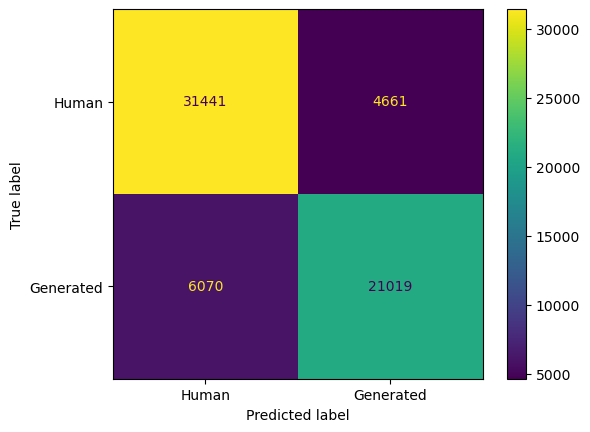

In [8]:
#### CNN Model

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(train_x_tfidf.shape[1], 1)))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(1, activation='sigmoid'))  
model_CNN.compile(loss='binary_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])


train_x_tfidf_reshaped = train_x_tfidf.reshape((train_x_tfidf.shape[0], train_x_tfidf.shape[1], 1))
valid_x_tfidf_reshaped = valid_x_tfidf.reshape((valid_x_tfidf.shape[0], valid_x_tfidf.shape[1], 1))
test_x_tfidf_reshaped = test_x_tfidf.reshape((test_x_tfidf.shape[0], test_x_tfidf.shape[1], 1))

model_CNN.fit(train_x_tfidf_reshaped, train_y, validation_data=(valid_x_tfidf_reshaped, valid_y), epochs=3)

valid_pred_y = (model_CNN.predict(valid_x_tfidf_reshaped) > 0.5).astype("int32").flatten() 
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = (model_CNN.predict(test_x_tfidf_reshaped) > 0.5).astype("int32").flatten() 
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [9]:
# Save the model in HDF5 format (single .h5 file)
model_CNN.save("model_CNN.h5")

Epoch 1/3


/home/yadagiri/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7099 - loss: 0.5084 - val_accuracy: 0.7270 - val_loss: 0.9912
Epoch 2/3
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7669 - loss: 0.4343 - val_accuracy: 0.7455 - val_loss: 1.0178
Epoch 3/3
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7930 - loss: 0.3946 - val_accuracy: 0.7589 - val_loss: 0.9772
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy:  0.7589134125636672
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Accuracy:  0.764032852779668
              precision    recall  f1-score   support

           0       0.72      0.96      0.82     36102
           1       0.91      0.50      0.64     27089

    accuracy                           0.76     63191
   macro avg       0.82      0.73      0.73     63191
weighted avg       0.80      0.76      0.75     63191



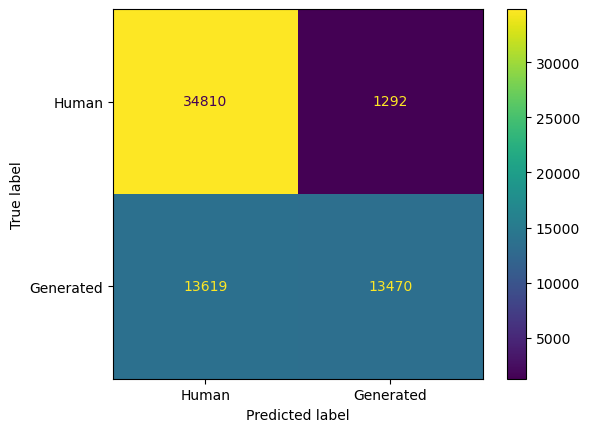

In [34]:
#### LSTM Model

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

model_LSTM = Sequential()
model_LSTM.add(Dense(128, activation='relu', input_shape=(train_x_tfidf.shape[1],))) 
model_LSTM.add(Dropout(0.5))  
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(1, activation='sigmoid'))  
model_LSTM.compile(loss='binary_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])
model_LSTM.fit(train_dataset, validation_data=valid_dataset, epochs=3)

valid_pred_y = (model_LSTM.predict(valid_dataset) > 0.5).astype("int32").flatten() 
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = (model_LSTM.predict(test_dataset) > 0.5).astype("int32").flatten()  
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['Human', 'Generated'])
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [35]:
model_LSTM.save("model_LSTM.h5")

Epoch 1/3


2024-10-08 15:42:35.179142: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5936080000 exceeds 10% of free system memory.


2319/2319 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7059 - loss: 0.5333 - val_accuracy: 0.7274 - val_loss: 0.9650
Epoch 2/3
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7629 - loss: 0.4396 - val_accuracy: 0.7321 - val_loss: 1.1113
Epoch 3/3
2319/2319 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.8042 - loss: 0.3777 - val_accuracy: 0.7404 - val_loss: 1.3376


2024-10-08 15:44:15.402687: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2527640000 exceeds 10% of free system memory.


988/988 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6462 - loss: 1.3132


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,205,317 (31.30 MB)

 Trainable params: 2,735,105 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,470,212 (20.87 MB)

Test Loss: 0.9536100625991821
Test Accuracy: 0.7381905913352966
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Accuracy:  0.7381905651121204
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     36102
           1       0.89      0.44      0.59     27089

    accuracy                           0.74     63191
   macro avg       0.79      0.70      0.70     63191
weighted avg       0.78      0.74      0.71     63191



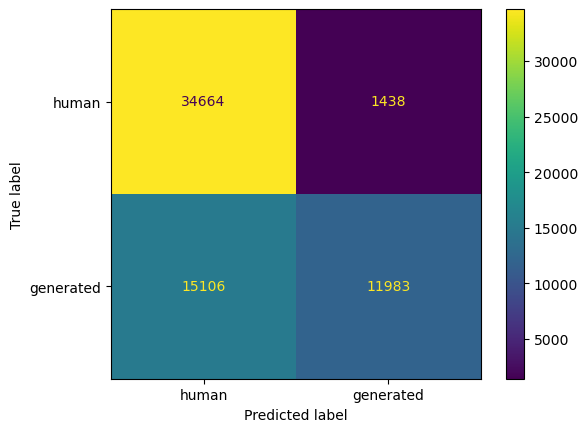

In [10]:
#### RNN Model

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_x_tfidf.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model_RNN.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model_RNN.fit(
    train_dataset,
    epochs=3,
    validation_data=valid_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


test_loss, test_acc = model_RNN.evaluate(test_dataset)
model_RNN.summary()

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

pred_prob = model_RNN.predict(test_x_tfidf)
pred_y = (pred_prob > 0.5).astype(int).flatten()  

print('Accuracy: ', accuracy_score(test_y, pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, pred_y), display_labels=['human', 'generated'])
cmd.plot()

report = classification_report(test_y, pred_y)
print(report)

In [11]:
model_RNN.save("model_RNN.h5")

In [12]:
#### Linear SVM Model

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

svm_model = svm.SVC(kernel='linear', probability=True)
svm_model.fit(train_x_tfidf, train_y)

valid_pred_y = svm_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = svm_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

NameError: name 'svm' is not defined

Validation Accuracy:  0.8057239873878244
Test Accuracy:  0.7902549413682328
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     36102
           1       0.77      0.73      0.75     27089

    accuracy                           0.79     63191
   macro avg       0.79      0.78      0.78     63191
weighted avg       0.79      0.79      0.79     63191



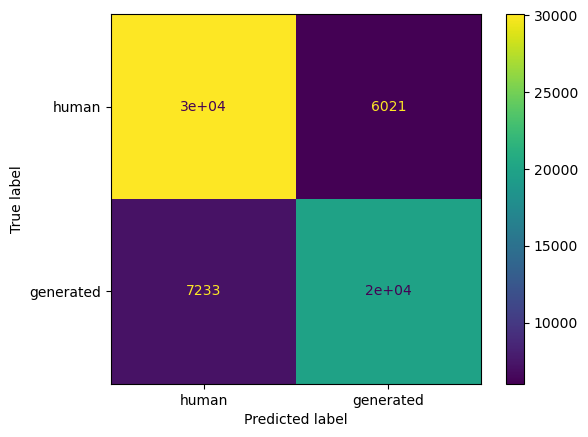

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Create the LinearSVC model
svm_model = LinearSVC()
svm_model.fit(train_x_tfidf, train_y)  # Train the model with training data

# Predict on validation set
valid_pred_y = svm_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

# Predict on test set
test_pred_y = svm_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

# Display confusion matrix for the test set
cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated'])
cmd.plot()

# Generate and print the classification report for the test set
report = classification_report(test_y, test_pred_y)
print(report)


In [14]:
!pip install joblib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [15]:
import joblib
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

Validation Accuracy:  0.6438879456706282
Test Accuracy:  0.6561377411340222
              precision    recall  f1-score   support

           0       0.64      0.91      0.75     36102
           1       0.73      0.31      0.44     27089

    accuracy                           0.66     63191
   macro avg       0.69      0.61      0.59     63191
weighted avg       0.68      0.66      0.62     63191



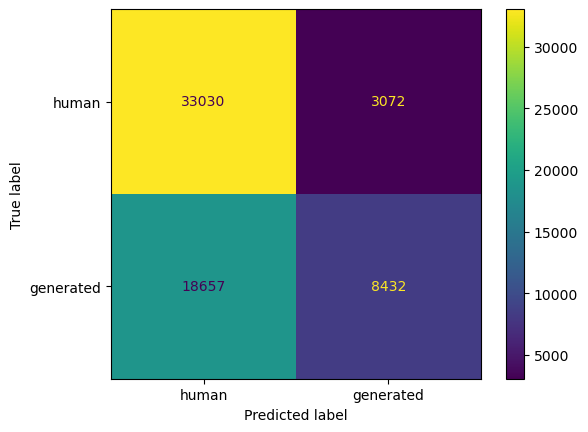

In [16]:
#### KNN Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_x_tfidf, train_y)

valid_pred_y = knn_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = knn_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated'])  
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)


In [17]:
joblib.dump(knn_model, 'knn_model.pkl')

['knn_model.pkl']

Validation Accuracy:  0.7426024739267524
Test Accuracy:  0.7359275846243927
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     36102
           1       0.70      0.67      0.68     27089

    accuracy                           0.74     63191
   macro avg       0.73      0.73      0.73     63191
weighted avg       0.73      0.74      0.74     63191



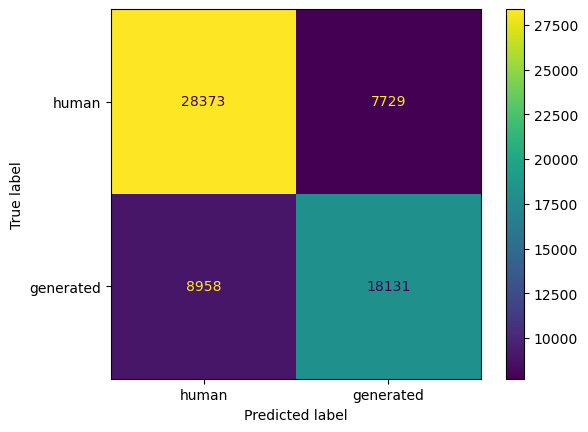

In [18]:
#### Decision Tree Model

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(train_x_tfidf, train_y)

valid_pred_y = dt_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = dt_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [19]:
joblib.dump(dt_model, 'dt_model.pkl')

['dt_model.pkl']

Validation Accuracy:  0.7293233082706767
Test Accuracy:  0.7145321327404219
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     36102
           1       0.69      0.62      0.65     27089

    accuracy                           0.71     63191
   macro avg       0.71      0.70      0.70     63191
weighted avg       0.71      0.71      0.71     63191



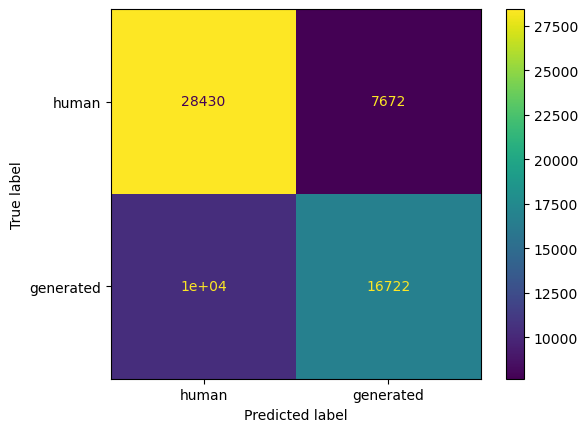

In [20]:
#### AdaBoost Model

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt_stump = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_model = AdaBoostClassifier(estimator=dt_stump, n_estimators=100, algorithm='SAMME', random_state=42)

ada_model.fit(train_x_tfidf, train_y)

valid_pred_y = ada_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = ada_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated'])
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [21]:
joblib.dump(ada_model, 'ada_model.pkl')

['ada_model.pkl']

Validation Accuracy:  0.793475624545234
Test Accuracy:  0.7949075026506939
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     36102
           1       0.82      0.67      0.74     27089

    accuracy                           0.79     63191
   macro avg       0.80      0.78      0.78     63191
weighted avg       0.80      0.79      0.79     63191



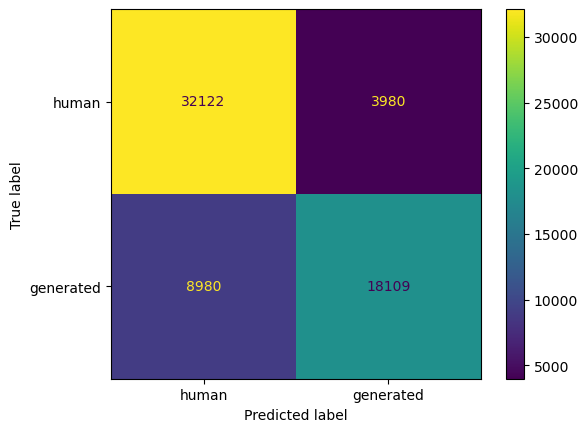

In [22]:
#### Bagging Classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(train_x_tfidf, train_y)

valid_pred_y = bagging_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = bagging_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [23]:
joblib.dump(bagging_model, 'bagging_model.pkl')

['bagging_model.pkl']

Validation Accuracy:  0.7845622119815668
Test Accuracy:  0.7738127264958617
              precision    recall  f1-score   support

           0       0.77      0.87      0.81     36102
           1       0.79      0.64      0.71     27089

    accuracy                           0.77     63191
   macro avg       0.78      0.76      0.76     63191
weighted avg       0.78      0.77      0.77     63191



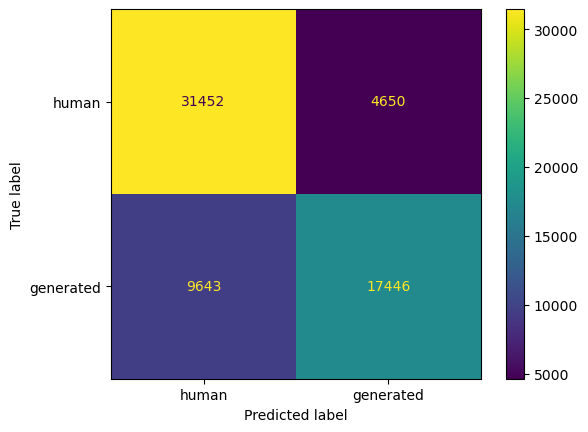

In [24]:
#### Gradient Boosting Model

from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gradient_boosting_model.fit(train_x_tfidf, train_y)

valid_pred_y = gradient_boosting_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = gradient_boosting_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated']) 
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [25]:
joblib.dump(gradient_boosting_model, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

Validation Accuracy:  0.8000242541838467
Test Accuracy:  0.8083271351933028
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     36102
           1       0.88      0.64      0.74     27089

    accuracy                           0.81     63191
   macro avg       0.83      0.79      0.79     63191
weighted avg       0.82      0.81      0.80     63191



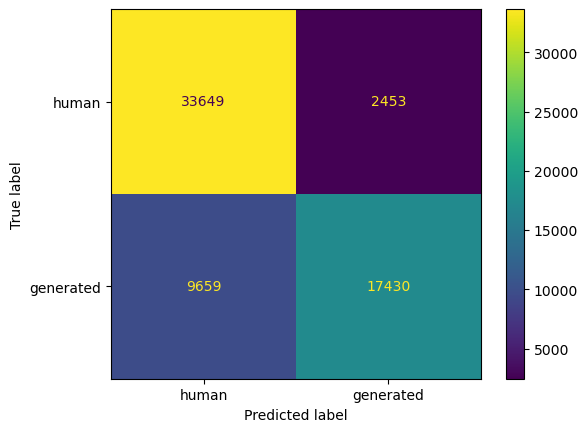

In [26]:
#### Random Forest Model

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(train_x_tfidf, train_y)

valid_pred_y = rf_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = rf_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated'])  # Assuming binary labels
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [27]:
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

Validation Accuracy:  0.790383216104778
Test Accuracy:  0.815163551771613
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     36102
           1       0.88      0.66      0.75     27089

    accuracy                           0.82     63191
   macro avg       0.83      0.80      0.80     63191
weighted avg       0.83      0.82      0.81     63191



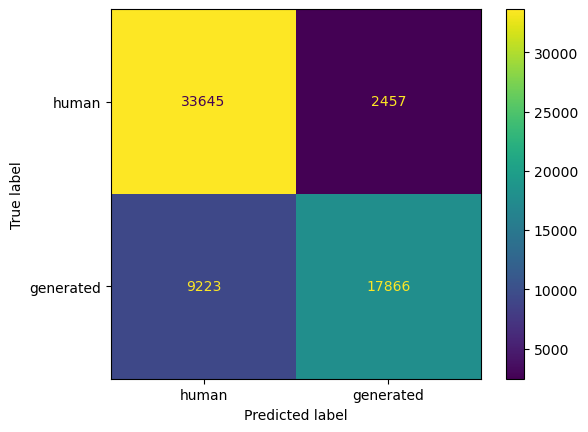

In [28]:
#### Extremely Randomized Trees (ExtraTreesClassifier) Model

from sklearn.ensemble import ExtraTreesClassifier

extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_model.fit(train_x_tfidf, train_y)

valid_pred_y = extra_trees_model.predict(valid_x_tfidf)
print("Validation Accuracy: ", accuracy_score(valid_y, valid_pred_y))

test_pred_y = extra_trees_model.predict(test_x_tfidf)
print("Test Accuracy: ", accuracy_score(test_y, test_pred_y))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, test_pred_y), display_labels=['human', 'generated'])  # Assuming binary labels
cmd.plot()

report = classification_report(test_y, test_pred_y)
print(report)

In [29]:
joblib.dump(extra_trees_model, 'extra_trees_model.pkl')

['extra_trees_model.pkl']

Validation Accuracy (Logistic Regression):  0.8004487024011642
Test Accuracy (Logistic Regression):  0.787659635074615
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     36102
           1       0.77      0.72      0.74     27089

    accuracy                           0.79     63191
   macro avg       0.78      0.78      0.78     63191
weighted avg       0.79      0.79      0.79     63191



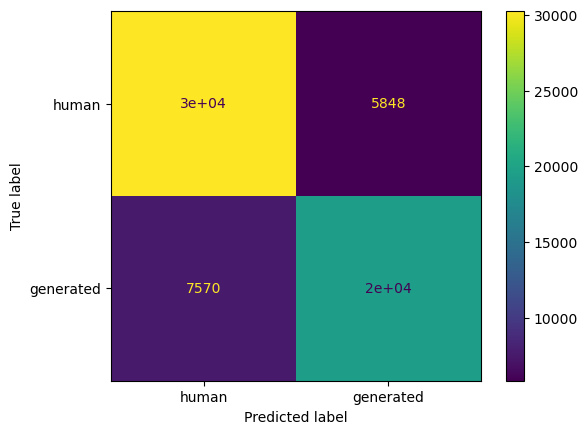

In [30]:
#### # Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_x_tfidf, train_y)

valid_pred_y = log_reg.predict(valid_x_tfidf)
print("Validation Accuracy (Logistic Regression): ", accuracy_score(valid_y, valid_pred_y))

log_reg_pred = log_reg.predict(test_x_tfidf)
print("Test Accuracy (Logistic Regression): ", accuracy_score(test_y, log_reg_pred))

cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, log_reg_pred), display_labels=['human', 'generated'])
cmd.plot()

log_reg_report = classification_report(test_y, log_reg_pred)
print(log_reg_report)

In [31]:
joblib.dump(log_reg, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

LDA MODEL

Validation Accuracy (LDA):  0.7983264613145767
Test Accuracy (LDA):  0.7840357012865756
              precision    recall  f1-score   support

           0       0.79      0.84      0.82     36102
           1       0.77      0.71      0.74     27089

    accuracy                           0.78     63191
   macro avg       0.78      0.77      0.78     63191
weighted avg       0.78      0.78      0.78     63191



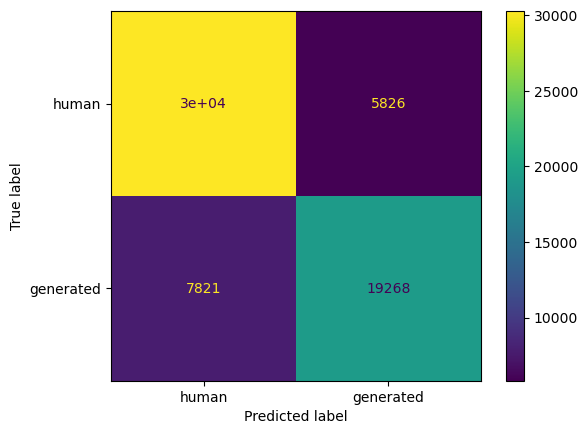

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_x_tfidf, train_y)
valid_pred_y = lda_model.predict(valid_x_tfidf)
print("Validation Accuracy (LDA): ", accuracy_score(valid_y, valid_pred_y))

lda_pred = lda_model.predict(test_x_tfidf)
print("Test Accuracy (LDA): ", accuracy_score(test_y, lda_pred))


cmd = ConfusionMatrixDisplay(confusion_matrix(test_y, lda_pred), display_labels=['human', 'generated'])
cmd.plot()

lda_report = classification_report(test_y, lda_pred)
print(lda_report)


In [33]:
joblib.dump(lda_model, 'lda_model.pkl')

['lda_model.pkl']

In [ ]:
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True)
acc_score = []
y2 = train_data['label']
# LDA
for train_index , test_index in kf.split(train_x_tfidf):
    X_train , X_test = X2[train_index] , X2[test_index]
    y_train , y_test = y2[train_index] , y2[test_index]
     
    lda.fit(X_train,y_train)
    pred_values = lda.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_values))

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy rf : {}'.format(avg_acc_score))


In [ ]:
from sklearn.model_selection import KFold
from sklearn.decomposition import LatentDirichletAllocation as LDA

k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True)
train_acc_score = []
valid_acc_score = []
test_acc_score = []

# Initialize LDA model
lda = LDA(n_components=2)

# Perform KFold Cross Validation
for train_index, test_index in kf.split(train_x_tfidf):
    X_train, X_test = train_x_tfidf[train_index], train_x_tfidf[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    
    lda.fit(X_train)
    
    train_pred_values = lda.transform(X_test).argmax(axis=1)  # Get the predicted labels by LDA
    
    # Predict on validation set
    valid_pred_values = lda.transform(valid_x_tfidf).argmax(axis=1)
    
    # Predict on test set
    test_pred_values = lda.transform(test_x_tfidf).argmax(axis=1)
    
    # Calculate accuracy for the train fold
    train_acc = accuracy_score(y_test, train_pred_values)
    train_acc_score.append(train_acc)
    
    # Calculate accuracy for the validation set
    valid_acc = accuracy_score(valid_y, valid_pred_values)
    valid_acc_score.append(valid_acc)
    
    # Calculate accuracy for the test set
    test_acc = accuracy_score(test_y, test_pred_values)
    test_acc_score.append(test_acc)

# Average accuracy over all folds for training, validation, and test sets
avg_train_acc_score = sum(train_acc_score) / k
avg_valid_acc_score = sum(valid_acc_score) / k
avg_test_acc_score = sum(test_acc_score) / k

# Final classification report for the last fold (as an example)
print(classification_report(test_y, test_pred_values))

# Output accuracy of each fold and average accuracy
print(f'Accuracy of each fold (Train): {train_acc_score}')
print(f'Average Train Accuracy: {avg_train_acc_score}')
print(f'Accuracy of each fold (Validation): {valid_acc_score}')
print(f'Average Validation Accuracy: {avg_valid_acc_score}')
print(f'Accuracy of each fold (Test): {test_acc_score}')
print(f'Average Test Accuracy: {avg_test_acc_score}')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
import numpy as np

# Assuming X2 and y2 are already defined
k = 10  # Number of splits for K-Fold
kf = KFold(n_splits=k, random_state=42, shuffle=True)
acc_score = []

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X2):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y2[train_index], y2[test_index]

    # Fit the model
    log_reg.fit(X_train, y_train)
    
    # Predict values
    pred_values = log_reg.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    # Optionally print the classification report for each fold
    print(classification_report(y_test, pred_values))

# Calculate average accuracy
avg_acc_score = np.mean(acc_score)

print('Accuracy of each fold: {}'.format(acc_score))
print('Avg accuracy (Logistic Regression): {}'.format(avg_acc_score))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming train_x_tfidf and train_y are already defined
k = 10  # Number of splits for K-Fold
kf = KFold(n_splits=k, random_state=42, shuffle=True)

acc_scores = []  # List to store accuracy scores for each fold

for train_index, valid_index in kf.split(train_x_tfidf):
    X_train, X_valid = train_x_tfidf[train_index], train_x_tfidf[valid_index]
    y_train, y_valid = train_y[train_index], train_y[valid_index]

    # Reshape the input for the CNN
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_reshaped = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

    # Define the CNN model
    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(128, activation='relu'))
    model_CNN.add(Dropout(0.5))
    model_CNN.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model_CNN.fit(X_train_reshaped, y_train, validation_data=(X_valid_reshaped, y_valid), epochs=3, verbose=1)

    # Predict on validation set
    valid_pred_y = (model_CNN.predict(X_valid_reshaped) > 0.5).astype("int32").flatten()

    # Calculate accuracy
    acc = accuracy_score(y_valid, valid_pred_y)
    acc_scores.append(acc)

    # Print classification report
    print("Classification report for fold:")
    print(classification_report(y_valid, valid_pred_y))

# Calculate and print average accuracy across all folds
avg_acc_score = np.mean(acc_scores)
print('Accuracy of each fold: {}'.format(acc_scores))
print('Avg accuracy (CNN): {}'.format(avg_acc_score))
